dict_keys(['zod_img_undist', 'mapil_image_undist', 'zod_pcd', 'zod_intrinsics_3x4'])


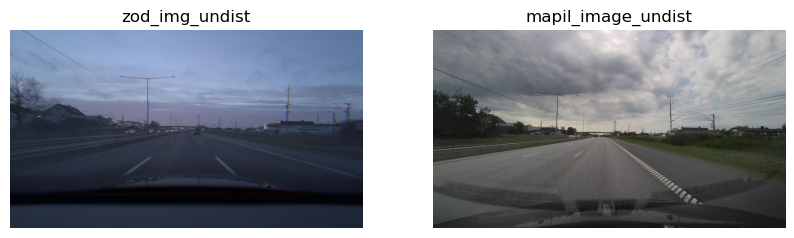

In [1]:
import numpy as np
import matplotlib.pyplot as plt

npy_path = "/home/bjangley/VPR/mast3r-v2/dict_mapil_zod.npy"

# Load the .npy file
data = np.load(npy_path, allow_pickle=True)

# To check the contents
dict = data.item()
print(dict.keys())

# Display zod_img_undist
img1 = dict['zod_img_undist']
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("zod_img_undist")
plt.axis('off')

# Display mapil_image_undist
img2 = dict['mapil_image_undist']
img2_flipped = np.flipud(img2)
plt.subplot(1,2,2)
plt.imshow(img2_flipped)
plt.title("mapil_image_undist")
plt.axis('off')
plt.show()

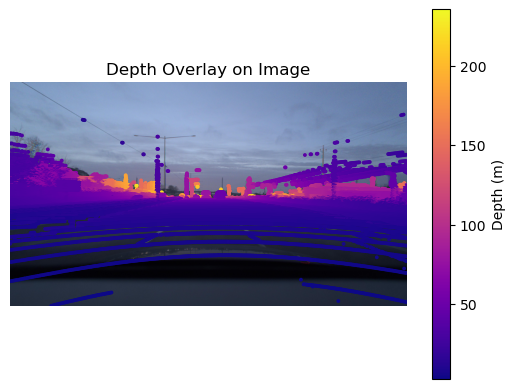

Master Dimensions 288 512


In [ ]:
from my_utils.my_vbr_dataset import generate_depth_and_scene_maps
from my_utils.mast3r_utils import plot_depth_overlay_on_image
H,W = img1.shape[:2]
K = dict['zod_intrinsics_3x4'][:3,:3]
T_cam_lidar = np.eye(4) #add T_cam_lidar here <---
depth_map, scene_map = generate_depth_and_scene_maps(dict['zod_pcd'],K,T_cam_lidar,img1.shape[:2])
v, u = np.where(np.isfinite(depth_map))
pixel_uv = np.stack((u, v), axis=-1)
plot_depth_overlay_on_image(img1,scene_map,pixel_uv)

from my_utils.mast3r_utils import get_mast3r_image_shape, get_master_output, scale_intrinsics, overlap
from PIL import Image
import os
### LOAD MAST3R MODEL 
from mast3r.model import AsymmetricMASt3R
device = 'cuda:4'
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

mast3r_w, mast3r_h = get_mast3r_image_shape(W, H)
K_new = scale_intrinsics(K, W, H, mast3r_w, mast3r_h)
print("Master Dimensions", mast3r_h, mast3r_w)

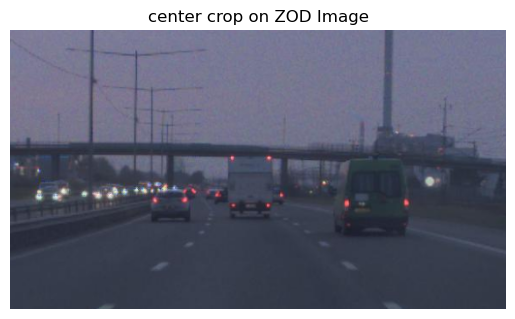

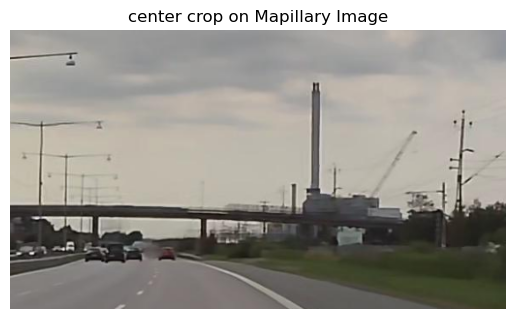

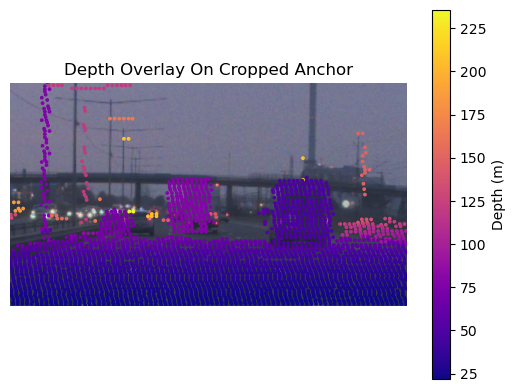

In [ ]:
import numpy as np
def center_crop_img(img, crop_h, crop_w):
    """
    Center crop an image (no depth or intrinsics).
    img: (H, W, 3) image
    crop_h, crop_w: desired crop size
    Returns: cropped_img
    """
    H, W = img.shape[:2]
    start_y = (H - crop_h) // 2
    start_x = (W - crop_w) // 2
    return img[start_y:start_y+crop_h, start_x:start_x+crop_w]

def center_crop_depth(img, depth_map, scene_map, K, crop_h, crop_w):
    """
    Center crop image and depth map, and adjust intrinsics.
    img: (H, W, 3) image
    depth: (H, W) depth map
    K: (3, 3) intrinsics
    crop_h, crop_w: desired crop size
    Returns: cropped_img, cropped_depth, new_K
    """
    H, W = img.shape[:2]
    start_y = (H - crop_h) // 2
    start_x = (W - crop_w) // 2

    cropped_img = img[start_y:start_y+crop_h, start_x:start_x+crop_w]
    cropped_depth_map = depth_map[start_y:start_y+crop_h, start_x:start_x+crop_w]
    cropped_scene_map= scene_map[start_y:start_y+mast3r_h, start_x:start_x+mast3r_w]
    # Adjust intrinsics: subtract crop offset from principal point
    new_K = K.copy()
    new_K[0, 2] -= start_x
    new_K[1, 2] -= start_y

    return cropped_img, cropped_depth_map, cropped_scene_map, new_K


# Example usage:
anchor_cropped, cropped_depth_map, cropped_scene_map, new_K = center_crop_depth(img1, depth_map,scene_map,K, mast3r_h, mast3r_w)
plt.imshow(anchor_cropped)
plt.title("center crop on ZOD Image")
plt.axis('off')
plt.show()

query_cropped = center_crop_img(img2_flipped, mast3r_h, mast3r_w)
plt.imshow(query_cropped)
plt.title("center crop on Mapillary Image")
plt.axis('off')
plt.show()

v, u = np.where(np.isfinite(cropped_depth_map))
pixel_uv = np.stack((u, v), axis=-1)
plot_depth_overlay_on_image(anchor_cropped,cropped_scene_map,pixel_uv,title="Depth Overlay On Cropped Anchor")


#image loading and saving
# Temporary directory to save images
tmp_dir = "/tmp/mast3r_images"
os.makedirs(tmp_dir, exist_ok=True)
# Save anchor and query images as PNGs
anchor_path = os.path.join(tmp_dir, "anchor.png")
query_path = os.path.join(tmp_dir, "query.png")
Image.fromarray(anchor_cropped).save(anchor_path)
Image.fromarray(query_cropped).save(query_path)

>> Loading a list of 2 images
 - adding /tmp/mast3r_images/anchor.png with resolution 512x288 --> 512x288
 - adding /tmp/mast3r_images/query.png with resolution 512x288 --> 512x288
 (Found 2 images)


/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


MASt3R Inference Time: 0.3815s


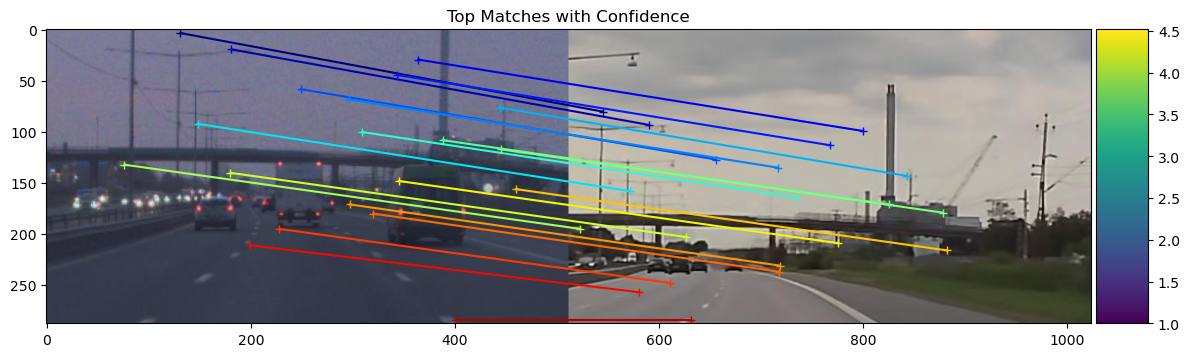

Fundamental matrix: 1092 matches, 939 inliers, 153 outliers


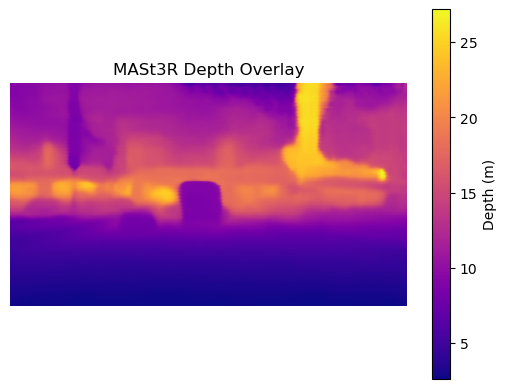

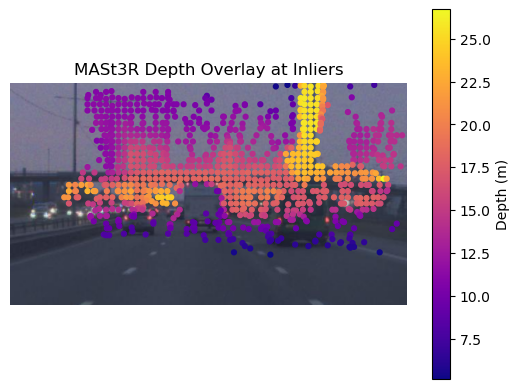

Recovered 176 matches with depth
Number of inlier matches: 176


In [ ]:
import cv2
output = get_master_output(model,device,anchor_path, query_path, visualize=True, verbose=True)
matches_im0 = output[0]
matches_im1 = output[1]
pts3d_im0   = output[2]
if len(matches_im0) >= 8:
    F, mask_f = cv2.findFundamentalMat(matches_im0, matches_im1, cv2.FM_RANSAC, 1, 0.99)
    num_inliers_f = int(mask_f.sum()) if mask_f is not None else 0
    inlier_mask = mask_f.ravel().astype(bool)
    inlier_im0 = matches_im0[inlier_mask]
    inlier_im1 = matches_im1[inlier_mask]
else:
    num_inliers_f = 0
    inlier_im0 = np.empty((0, 2))
    inlier_im1 = np.empty((0, 2))
print(f"Fundamental matrix: {len(matches_im0)} matches, {num_inliers_f} inliers, {len(matches_im0) - num_inliers_f} outliers")

H, W, _ = pts3d_im0.shape 
u_grid, v_grid = np.meshgrid(np.arange(W), np.arange(H)) #mast3r image shape
all_uv = np.stack([u_grid.ravel(), v_grid.ravel()], axis=-1)  # shape (H*W, 2)
## visualise mast3r depth maps
# if num_inliers_f > 0:
#     plot_depth_overlay_on_image(
#         anchor_cropped,
#         pts3d_im0,
#         all_uv,
#         point_size=12,
#         cmap='plasma',
#         alpha=1.0,
#         title="MASt3R Depth Overlay"
#     )

# if num_inliers_f > 0:
#     plot_depth_overlay_on_image(
#         anchor_cropped,
#         pts3d_im0,
#         inlier_im0,
#         point_size=12,
#         cmap='plasma',
#         alpha=1.0,
#         title="MASt3R Depth Overlay at Inliers"
#     )

matched_uv, matched_lidar_uv, matched_indices = overlap(inlier_im0, cropped_depth_map, max_pixel_dist=4)
inlier_im0 = inlier_im0[matched_indices]
inlier_im1 = inlier_im1[matched_indices]
print(f"Recovered {len(matched_uv)} matches with depth")
print(f"Number of inlier matches: {len(inlier_im0)}")


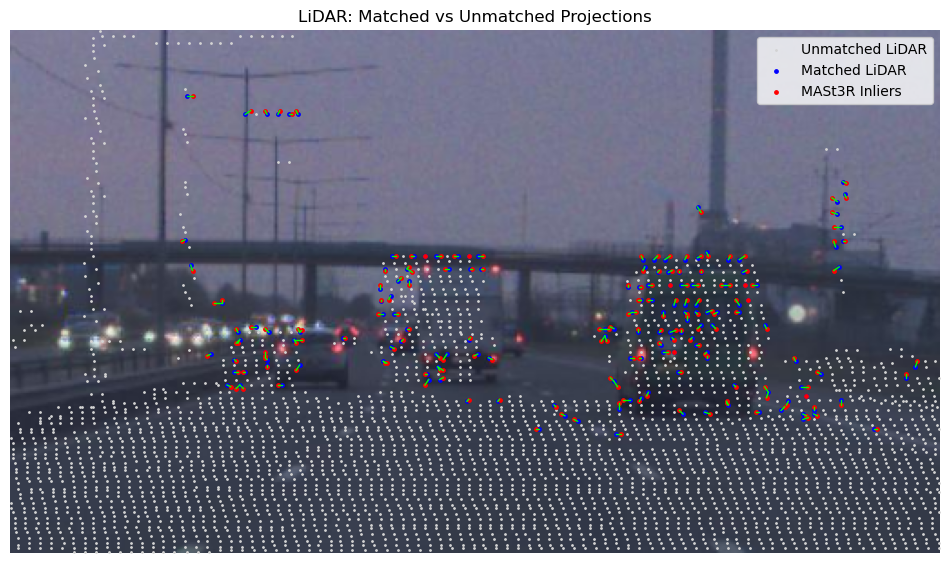

In [9]:
def plot_lidar_mast3r_matches(img, lidar_uv, matched_lidar_uv, inliers_im0, title="LiDAR: Matched vs Unmatched Projections"):
    """
    Visualize matched/unmatched LiDAR projections and MASt3R inlier matches.

    Args:
        img: Image array (background for scatter plot)
        lidar_uv: (N,2) array of all valid LiDAR-projected pixel coordinates
        matched_lidar_uv: (M,2) array of matched LiDAR pixel coordinates
        inliers_im0: (M,2) array of MASt3R inlier keypoints
          (matched to LiDAR)
        title: Plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np

    matched_lidar_uv_set = set(map(tuple, matched_lidar_uv))
    mask_matched = np.array([tuple(uv) in matched_lidar_uv_set for uv in lidar_uv])
    lidar_matched_uv = lidar_uv[mask_matched]
    lidar_unmatched_uv = lidar_uv[~mask_matched]
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    if len(lidar_unmatched_uv) > 0:
        plt.scatter(lidar_unmatched_uv[:, 0], lidar_unmatched_uv[:, 1], c='lightgray', s=1, label='Unmatched LiDAR')
    if len(lidar_matched_uv) > 0:
        plt.scatter(lidar_matched_uv[:, 0], lidar_matched_uv[:, 1], c='blue', s=6, label='Matched LiDAR')
    if len(inliers_im0) > 0:
        plt.scatter(inliers_im0[:, 0], inliers_im0[:, 1], c='red', s=6, label='MASt3R Inliers')
        # Draw lines between inlier keypoints and matched LiDAR
        for match_uv, lidar_uv_ in zip(inliers_im0, matched_lidar_uv):
            plt.plot([match_uv[0], lidar_uv_[0]], [match_uv[1], lidar_uv_[1]], color='lime', linewidth=1)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()


# Prepare lidar_uv as before
v_all, u_all = np.where(np.isfinite(cropped_depth_map))
lidar_uv = np.stack((u_all, v_all), axis=-1)

plot_lidar_mast3r_matches(
    anchor_cropped,
    lidar_uv,
    matched_lidar_uv,
    inlier_im0
)

In [ ]:
# Compute all localizations for the loaded anchor-query pair

from my_utils.scaling import compute_scaled_points
from my_utils.transformations import se3_to_pose, pose_to_se3
from my_utils.mast3r_utils import solve_pnp

# --- Prepare inlier 3D-2D correspondences ---
if len(inlier_im0) >= 4:
    mast3r_pts = pts3d_im0[inlier_im0[:, 1].astype(int), inlier_im0[:, 0].astype(int)]
    lidar_pts = cropped_scene_map[matched_lidar_uv[:, 1].astype(int), matched_lidar_uv[:, 0].astype(int)]
    inlier_2d = inlier_im1.astype(np.float32)
else:
    mast3r_pts = np.empty((0, 3))
    lidar_pts = np.empty((0, 3))
    inlier_2d = np.empty((0, 2))


# --- PnP from MASt3R ---
T_query_anchor_mast3r = solve_pnp(mast3r_pts, inlier_2d, K_new) if len(mast3r_pts) >= 4 else None

# --- PnP from LiDAR ---
T_query_anchor_lidar = solve_pnp(lidar_pts, inlier_2d, K_new) if len(lidar_pts) >= 4 else None

# --- MASt3R scaled v3 (L1 centroid scale) ---
mast3r_pts_scaled_v3, scale_v3 = compute_scaled_points('v3', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v3 is not None:
    print(f"Scale estimated for v3 (L1 centroid scale): {scale_v3}")
T_query_anchor_scaled_v3 = solve_pnp(mast3r_pts_scaled_v3, inlier_2d, K_new) if mast3r_pts_scaled_v3.size > 0 else None

# --- MASt3R scaled v4 (per-axis L1 scale) ---
mast3r_pts_scaled_v4, scale_v4 = compute_scaled_points('v4', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v4 is not None:
    print(f"Scale estimated for v4 (per-axis L1 scale): {scale_v4}")
T_query_anchor_scaled_v4 = solve_pnp(mast3r_pts_scaled_v4, inlier_2d, K_new) if mast3r_pts_scaled_v4.size > 0 else None

# --- MASt3R scaled ICP (Umeyama) ---
mast3r_pts_scaled_icp, scale_icp = compute_scaled_points('icp', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_icp is not None:
    print(f"Scale estimated for ICP (Umeyama): {scale_icp}")
T_query_anchor_scaled_icp = solve_pnp(mast3r_pts_scaled_icp, inlier_2d, K_new) if mast3r_pts_scaled_icp.size>=4 else None


Scale estimated for v3 (L1 centroid scale): 5.430157850530252
Scale estimated for v4 (per-axis L1 scale): [2.238944  2.7156203 5.603172 ]
Scale estimated for ICP (Umeyama): 1.420205207611779


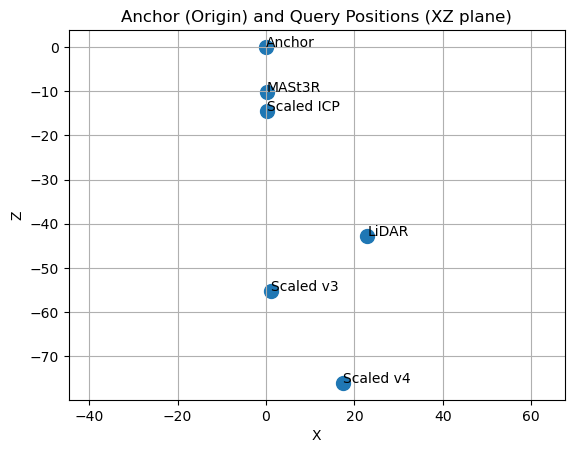

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

##plotting xz plot
transforms = [
    T_query_anchor_mast3r,
    T_query_anchor_lidar,
    T_query_anchor_scaled_v3,
    T_query_anchor_scaled_v4,
    T_query_anchor_scaled_icp
]

labels = [
    'MASt3R',
    'LiDAR',
    'Scaled v3',
    'Scaled v4',
    'Scaled ICP'
]

# Get XZ positions
xs, zs = [0], [0]           # Start with anchor at (0,0)
all_labels = ['Anchor']
for T, label in zip(transforms, labels):
    if T is not None:
        xs.append(T[0,3])
        zs.append(T[2,3])
        all_labels.append(label)

# Plot
plt.scatter(xs, zs, s=100)
for x, z, label in zip(xs, zs, all_labels):
    plt.text(x, z, label, fontsize=10)

plt.xlabel('X')
plt.ylabel('Z')
plt.title('Anchor (Origin) and Query Positions (XZ plane)')
plt.grid(True)
plt.axis('equal')
plt.show()
